## AlekseevDP(DSU-4,DLL-15)_HW#12_Работа с текстом (Word2Vec vs FastText)

1) Скачать датасет с фразами Cимпсонов - https://github.com/sujanjoejacob/Text-mining-with-Simpsons-Data

2) Обучить FastText/Word2vec на фразах персонажей

3) Найти самые близкие слова для: 
- homer - marge + bart
-  bart - lisa + school 
- marge - homer + home

4) Визуализировать embeddings по самым частотным словам (top 1000)



## 1. Загрузим и предобработаем данные (лемматизируем, разобьем на токены)

In [1]:
!wget 'https://github.com/sujanjoejacob/Text-mining-with-Simpsons-Data/raw/master/simpsons_script_lines.csv.zip'

--2023-01-21 16:44:13--  https://github.com/sujanjoejacob/Text-mining-with-Simpsons-Data/raw/master/simpsons_script_lines.csv.zip
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/sujanjoejacob/Text-mining-with-Simpsons-Data/master/simpsons_script_lines.csv.zip [following]
--2023-01-21 16:44:14--  https://raw.githubusercontent.com/sujanjoejacob/Text-mining-with-Simpsons-Data/master/simpsons_script_lines.csv.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9163442 (8.7M) [application/zip]
Saving to: ‘simpsons_script_lines.csv.zip’

simpsons_script_lin 100%[===================>]   8.74M  50.6MB/s

In [2]:
!unzip 'simpsons_script_lines.csv.zip'

Archive:  simpsons_script_lines.csv.zip
  inflating: simpsons_script_lines.csv  


In [3]:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
import regex
from tqdm import tqdm
tqdm.pandas()
from scipy import sparse

In [5]:
!pip install gensim

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
import gensim
print(gensim.__version__)

3.6.0


In [7]:
from gensim import models

In [8]:
from nltk.tokenize import word_tokenize
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [9]:
# загрузим знаки пунктуации
from string import punctuation
punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [10]:
import re
from nltk.corpus import stopwords

In [11]:
!pip install pymorphy2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 KB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 57.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13723 sha256=e253b8a8b9f013406db66c359d1efde8f04b03ca339a254e74c8fe24da674779
  Stored in directory: /root/.cache/pip/wheels/56/ea/58/ead137b087d9e326852a851351d1debf4ada529b6ac0ec4e8c
Successfully built docopt


In [12]:
import pymorphy2

In [13]:
m = pymorphy2.MorphAnalyzer()

In [14]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [15]:
mystopwords = stopwords.words('english') + list(punctuation)  #добавим знаки пунктуации к списку стоп-слов
en_words = re.compile("[A-Za-z]+")

def words_only(txt):
    return " ".join(en_words.findall(txt))

def lemmatize(txt):
    try:
        return  " ".join([m.parse(w)[0].normal_form for w in txt.lower().split()])
    except:
        return " "

def remove_stopwords(txt, mystopwords = mystopwords):
    try:
        return " ".join([token for token in txt.split() if not token in mystopwords])
    except:
        return ""

# препроцессинг с лемматизацией   
def preprocess(txt):
    return remove_stopwords(lemmatize(words_only(txt.lower())))

In [16]:
df = pd.read_csv("/content/simpsons_script_lines.csv", on_bad_lines='skip')

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (4,5,6) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158248 entries, 0 to 158247
Data columns (total 13 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   id                  158248 non-null  int64  
 1   episode_id          158248 non-null  int64  
 2   number              158248 non-null  int64  
 3   raw_text            158248 non-null  object 
 4   timestamp_in_ms     158248 non-null  object 
 5   speaking_line       158248 non-null  object 
 6   character_id        140727 non-null  object 
 7   location_id         157841 non-null  float64
 8   raw_character_text  140726 non-null  object 
 9   raw_location_text   157840 non-null  object 
 10  spoken_words        132089 non-null  object 
 11  normalized_text     132064 non-null  object 
 12  word_count          132089 non-null  float64
dtypes: float64(2), int64(3), object(8)
memory usage: 15.7+ MB


In [18]:
df['normalized_text'][:10]

0    no actually it was a little of both sometimes ...
1                                  wheres mr bergstrom
2    i dont know although id sure like to talk to h...
3                            that life is worth living
4    the polls will be open from now until the end ...
5             i dont think theres anything left to say
6                                                 bart
7                        victory party under the slide
8                                                  NaN
9                            mr bergstrom mr bergstrom
Name: normalized_text, dtype: object

In [19]:
# удалим NaN'ы
df = df[df['normalized_text'].notnull()]

In [20]:
df['normalized_text'][:10]

0     no actually it was a little of both sometimes ...
1                                   wheres mr bergstrom
2     i dont know although id sure like to talk to h...
3                             that life is worth living
4     the polls will be open from now until the end ...
5              i dont think theres anything left to say
6                                                  bart
7                         victory party under the slide
9                             mr bergstrom mr bergstrom
10    hey hey he moved out this morning he must have...
Name: normalized_text, dtype: object

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 132064 entries, 0 to 158247
Data columns (total 13 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   id                  132064 non-null  int64  
 1   episode_id          132064 non-null  int64  
 2   number              132064 non-null  int64  
 3   raw_text            132064 non-null  object 
 4   timestamp_in_ms     132064 non-null  object 
 5   speaking_line       132064 non-null  object 
 6   character_id        132062 non-null  object 
 7   location_id         131687 non-null  float64
 8   raw_character_text  132062 non-null  object 
 9   raw_location_text   131687 non-null  object 
 10  spoken_words        132064 non-null  object 
 11  normalized_text     132064 non-null  object 
 12  word_count          132064 non-null  float64
dtypes: float64(2), int64(3), object(8)
memory usage: 14.1+ MB


In [22]:
# лемматизируем выборку
lemmas = df['normalized_text'].astype('str').progress_apply(preprocess)

100%|██████████| 132064/132064 [00:39<00:00, 3328.14it/s]


In [23]:
lemmas[:1]

0    actually little sometimes disease magazines ne...
Name: normalized_text, dtype: object

In [24]:
# сделаем простейшую токенизацию
sentences = []
for line in lemmas:
    sentences.append(line.split(' '))

In [25]:
sentences[:1]

[['actually',
  'little',
  'sometimes',
  'disease',
  'magazines',
  'news',
  'shows',
  'natural',
  'think']]

## 2.1. Обучим модель word2vec

In [26]:
from gensim.models import Word2Vec

In [27]:
model_Word2Vec = Word2Vec()
model_Word2Vec.build_vocab(sentences)

In [28]:
model_Word2Vec.train(sentences, total_examples=model_Word2Vec.corpus_count, epochs=model_Word2Vec.epochs)

(3203321, 3735775)

In [29]:
from numpy import dot
from numpy.linalg import norm

def cos_sim(x, y):
    return dot(x, y) / (norm(x) * norm(y))

In [30]:
try:
    print(cos_sim(model_Word2Vec.wv['little'], model_Word2Vec.wv['big']))
    print(cos_sim(model_Word2Vec.wv['actually'], model_Word2Vec.wv['actual']))
    print(cos_sim(model_Word2Vec.wv['man'], model_Word2Vec.wv['woman']))
    print(cos_sim(model_Word2Vec.wv['sometimes'], model_Word2Vec.wv['times']))
except Exception as e:
    print(e)

0.47357032
0.7121379
0.74996096
0.37657028


## 2.2. Обучим модель FastText

In [31]:
# model_FastText = models.FastText(sentences, sg=1, vector_size=50)
model_FastText = models.FastText(sentences, sg=1, size=50)

In [32]:
try:
    print(cos_sim(model_FastText.wv['little'], model_FastText.wv['big']))
    print(cos_sim(model_FastText.wv['actually'], model_FastText.wv['actual']))
    print(cos_sim(model_FastText.wv['man'], model_FastText.wv['woman']))
    print(cos_sim(model_FastText.wv['sometimes'], model_FastText.wv['times']))
except Exception as e:
    print(e)

0.55165935
0.91171324
0.78283745
0.7473359


## 3.  Найти самые близкие слова для:
- homer - marge + bart
-  bart - lisa + school 
- marge - homer + home

 Пример:  vector[Queen] =  vector[King]  - vector[Man] + vector[Woman],
 
  trained_model.most_similar(positive=['woman', 'king'], negative=['man']) >>  Ответ: 'queen'

## 3.1. homer - marge + bart

In [33]:
# а) Word2Vec
model_Word2Vec.wv.most_similar(positive=['homer', 'bart'], negative=['marge'])

[('lisa', 0.8308601379394531),
 ('genes', 0.7350929975509644),
 ('mrs', 0.7206010818481445),
 ('eliza', 0.715149462223053),
 ('bartholomew', 0.7146998643875122),
 ('abe', 0.7107939720153809),
 ('grampa', 0.7021749019622803),
 ('abraham', 0.6884813904762268),
 ('j', 0.6881412863731384),
 ('dontcha', 0.6701034307479858)]

In [34]:
# b) FastText
model_FastText.wv.most_similar(positive=['homer', 'bart'], negative=['marge'])

[('barto', 0.8035179376602173),
 ('barts', 0.784798264503479),
 ('bartron', 0.7698180675506592),
 ('bartholomew', 0.7674950957298279),
 ('bartman', 0.7600305676460266),
 ('grampa', 0.7581705451011658),
 ('barty', 0.7511806488037109),
 ('lisa', 0.7454352378845215),
 ('bartender', 0.7418060302734375),
 ('grampas', 0.7410783767700195)]

## 3.2. bart - lisa + school

In [35]:
# а) Word2Vec
model_Word2Vec.wv.most_similar(positive=['bart', 'school'], negative=['lisa'])

[('rest', 0.827364444732666),
 ('time', 0.8038192987442017),
 ('together', 0.8030805587768555),
 ('christmas', 0.7971259355545044),
 ('weekend', 0.7929500937461853),
 ('town', 0.7902951240539551),
 ('tv', 0.7813491821289062),
 ('church', 0.7803770899772644),
 ('tomorrow', 0.7786523699760437),
 ('bus', 0.7781610488891602)]

In [36]:
# b) FastText
model_FastText.wv.most_similar(positive=['bart', 'school'], negative=['lisa'])

[('schoolyard', 0.8779957294464111),
 ('schools', 0.8660482168197632),
 ('schoolgirl', 0.8332592248916626),
 ('scheme', 0.7917921543121338),
 ('teacher', 0.791325569152832),
 ('teachers', 0.7825798988342285),
 ('teaches', 0.7799399495124817),
 ('study', 0.7785851955413818),
 ('stud', 0.7773411870002747),
 ('classroom', 0.7738521695137024)]

## 3.3. marge - homer + home

In [37]:
# а) Word2Vec
model_Word2Vec.wv.most_similar(positive=['marge', 'home'], negative=['homer'])

[('bed', 0.8746695518493652),
 ('sleep', 0.8309627175331116),
 ('together', 0.8308621048927307),
 ('back', 0.8009642958641052),
 ('stay', 0.7978423833847046),
 ('free', 0.7791279554367065),
 ('house', 0.7782691717147827),
 ('tomorrow', 0.7728051543235779),
 ('outta', 0.7683703899383545),
 ('boys', 0.7662200331687927)]

In [38]:
# b) FastText
model_FastText.wv.most_similar(positive=['marge', 'home'], negative=['homer'])

[('homey', 0.7657917737960815),
 ('hom', 0.7647693753242493),
 ('homes', 0.7493239641189575),
 ('bed', 0.7413483262062073),
 ('bedroom', 0.7412833571434021),
 ('homies', 0.7356932759284973),
 ('homemade', 0.7352703809738159),
 ('palace', 0.734828770160675),
 ('upstairs', 0.7339038848876953),
 ('honey', 0.7334530353546143)]

## 4. Визуализация embeddings по самым частотным словам (top 1000)

## 4.1 Визуализация embeddings топ-1000 слов, полученных с помощью модели Word2Vec

In [39]:
# top_1000_Word2Vec = model_Word2Vec.wv.index_to_key[:1000] 
top_1000_Word2Vec = model_Word2Vec.wv.index2entity[:1000] 

In [40]:
# посмотрим на топ-20 слов (для примера и дальнейшего сравнения с моделью FastText)
top_1000_Word2Vec[:20]

['im',
 'oh',
 'well',
 'dont',
 'like',
 'get',
 'youre',
 'one',
 'know',
 'thats',
 'hey',
 'homer',
 'right',
 'go',
 'got',
 'bart',
 'ill',
 'uh',
 'good',
 'see']

In [41]:
# Нам необходимо работать не со словами, а с векторами. Поэтому преобразуем топ-1000 слов модели Word2Vec в эмбеддинги 
X_Word2Vec = model_Word2Vec[top_1000_Word2Vec]

<ipython-input-41-e520f4efb04c>:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  X_Word2Vec = model_Word2Vec[top_1000_Word2Vec]


In [42]:
X_Word2Vec[:1]

array([[-0.86054695, -0.3100711 ,  0.9503106 , -0.21157774,  0.9146935 ,
        -0.8699949 ,  0.20472345,  0.49279052, -1.030185  ,  0.22442353,
         0.1800856 , -0.11526366, -0.25072372, -0.36004654, -0.42273924,
         0.3387835 , -0.00946783,  0.3520234 , -0.31449625, -0.70651203,
         0.33078825,  0.49801502,  0.49063185, -0.5678358 , -1.3100215 ,
         0.08133373,  0.924903  , -1.1894727 ,  0.8884899 ,  0.45959756,
        -1.568867  , -0.74528944, -0.8436964 , -0.44246796,  0.42094105,
         2.1123416 ,  0.3170319 ,  0.70900065, -0.8186045 ,  0.55179244,
         1.840942  ,  0.32227722,  0.1541616 , -1.4092788 ,  0.5461558 ,
        -0.32796592, -0.68458515,  0.44264865,  0.10538026,  0.2392822 ,
         0.8874909 , -0.6106499 , -0.42826346,  0.00959731, -0.10512294,
         0.06063713,  0.2599313 ,  0.25714612,  0.20020592,  0.96821386,
        -0.9570904 ,  0.7313663 ,  0.10717853,  0.17846553, -0.511256  ,
        -1.9978105 ,  1.2807893 ,  0.37209937, -0.5

In [43]:
# Для визуализации эмбеддингов воспользуемся методом главных компонент, понизив размерность до 2-х
from sklearn.decomposition import PCA

In [44]:
pca = PCA(n_components=2)
result_Word2Vec = pca.fit_transform(X_Word2Vec)

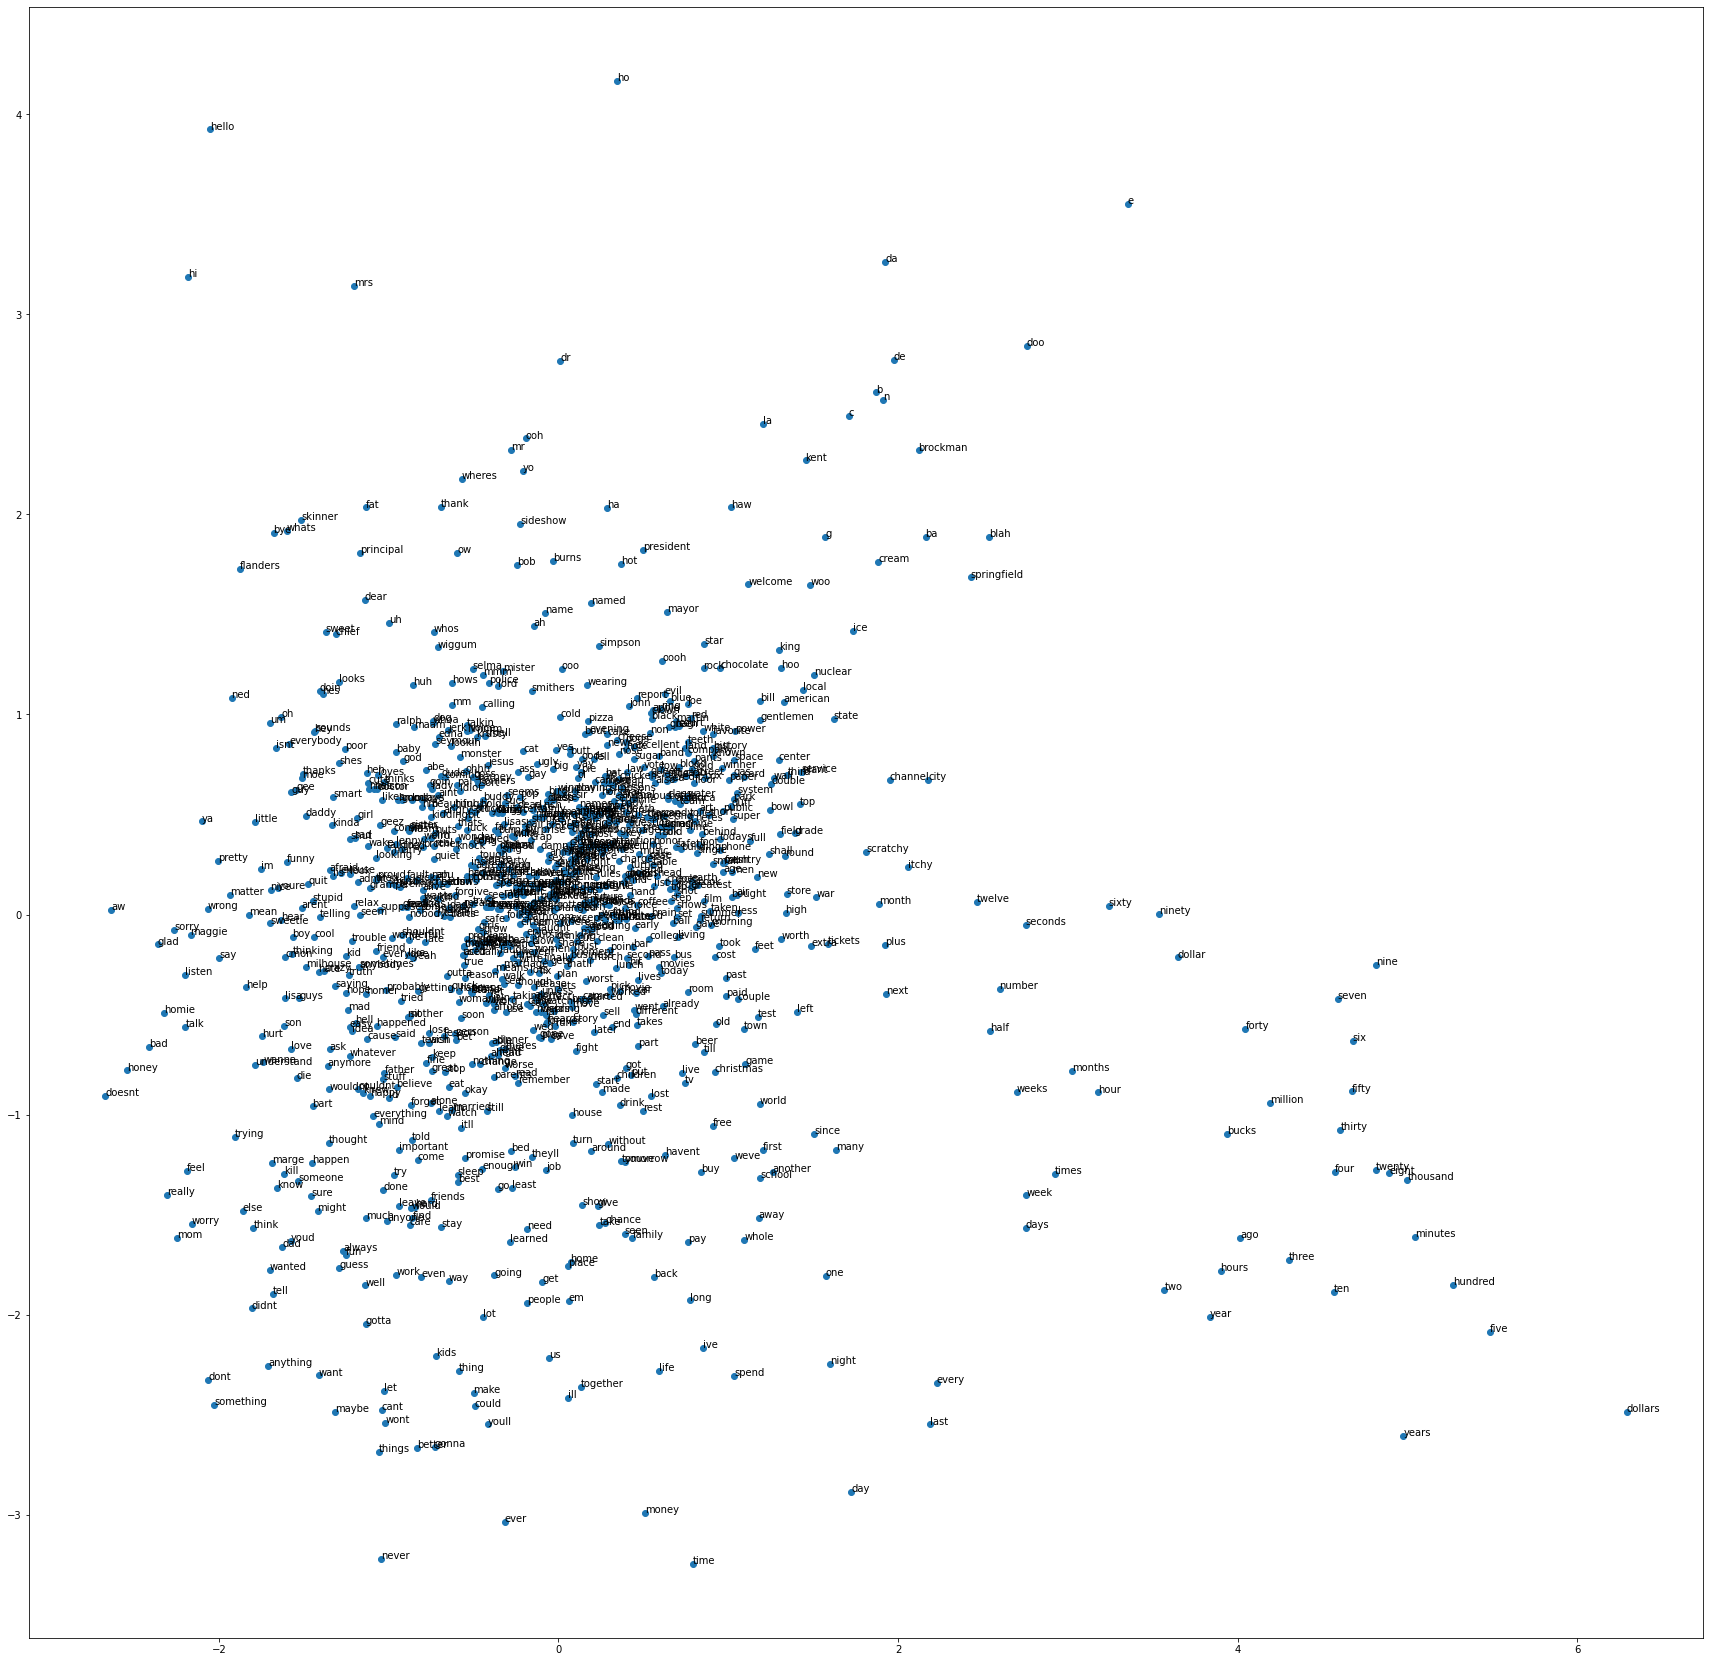

In [45]:
plt.scatter(result_Word2Vec[:, 0], result_Word2Vec[:, 1])

for i, word in enumerate(top_1000_Word2Vec):
  plt.annotate(word, xy=[result_Word2Vec[i, 0], result_Word2Vec[i, 1]])
plt.gcf().set_size_inches(30, 30)

## 4.2 Визуализация embeddings топ-1000 слов, полученных с помощью модели FastText

In [46]:
top_1000_FastText = model_FastText.wv.index2entity[:1000] 

In [47]:
# посмотрим на топ-20 слов модели FastText
top_1000_FastText[:20]

['im',
 'oh',
 'well',
 'dont',
 'like',
 'get',
 'youre',
 'one',
 'know',
 'thats',
 'hey',
 'homer',
 'right',
 'go',
 'got',
 'bart',
 'ill',
 'uh',
 'good',
 'see']

## Мы видим, что, по крайней мере, топ-20 слов модели FastText совпадают с топ-20 модели Word2Vec. Но эмбеддинги слов, построенные моделями, скорее всего отличаются. Построим визуализацию топ-1000 для модели FastText и сравним

In [48]:
# Нам необходимо работать не со словами, а с векторами. Поэтому преобразуем топ-1000 слов модели FastText в эмбеддинги 
X_FastText = model_FastText[top_1000_FastText]

<ipython-input-48-a54031bc93a2>:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  X_FastText = model_FastText[top_1000_FastText]


In [49]:
pca = PCA(n_components=2)
result_FastText = pca.fit_transform(X_FastText)

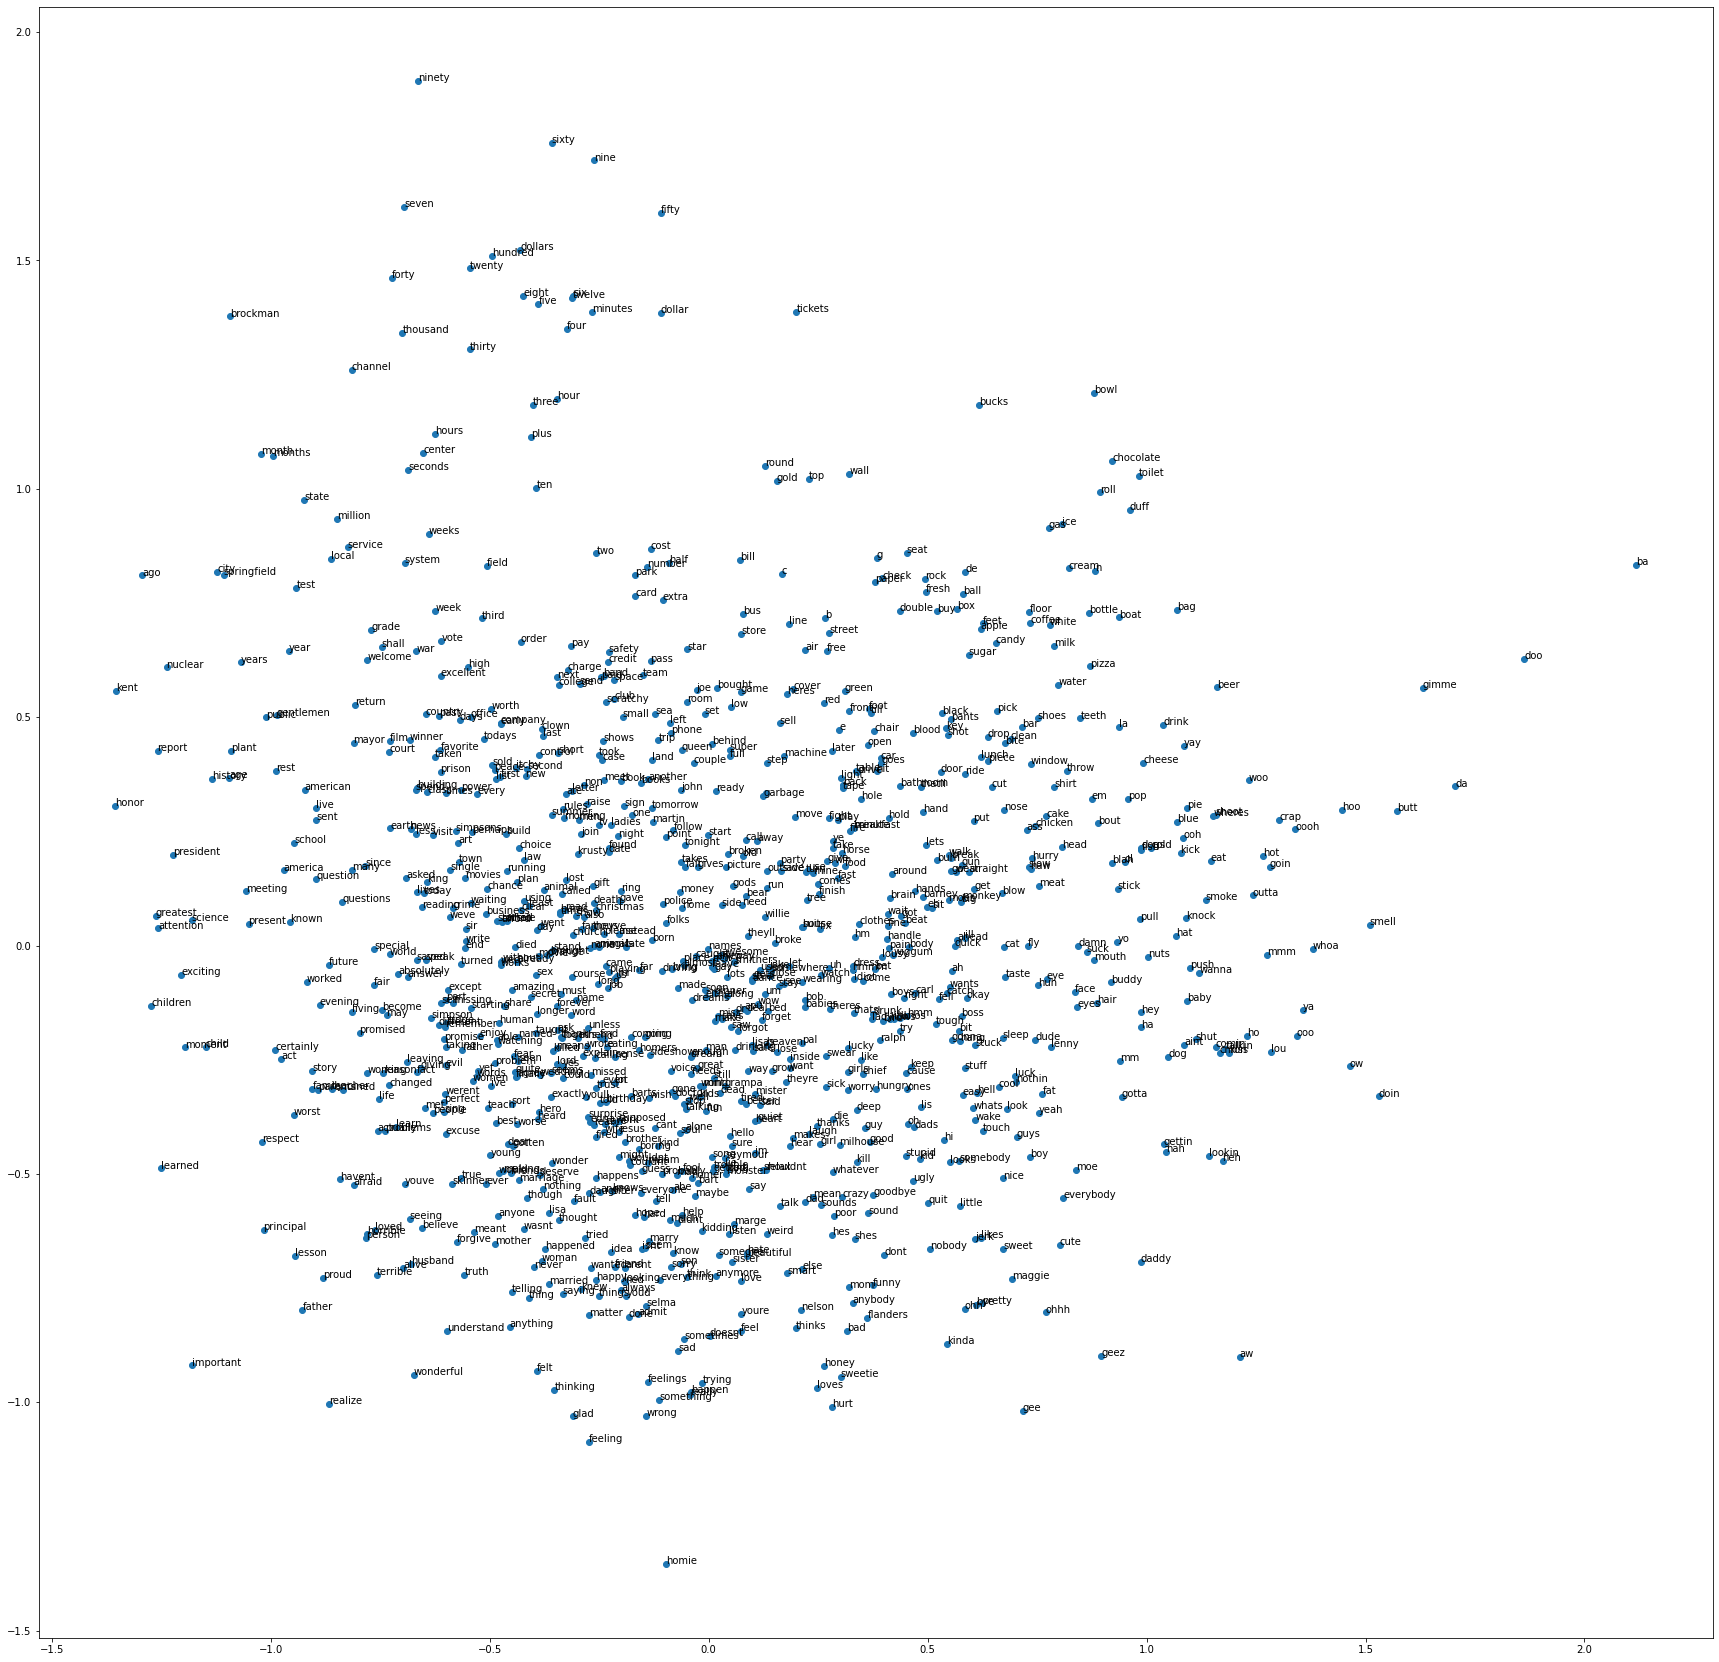

In [50]:
plt.scatter(result_FastText[:, 0], result_FastText[:, 1])

for i, word in enumerate(top_1000_FastText):
  plt.annotate(word, xy=[result_FastText[i, 0], result_FastText[i, 1]])
plt.gcf().set_size_inches(30, 30)

## По визуализациям можно сделать вывод, что при заданных параметрах модель FastText построила более точные/близкие эмбеддинги, чем Word2Vec (семантически близкие слова на визуализации топ-1000 FastText находятся ближе друг к другу и лучше кластеризованы, чем на визуализации топ-1000 Word2Vec).